<a href="https://colab.research.google.com/github/BQ-QB/Epidemic-Containment-Strategy-Modell/blob/main/SIR_graphic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hej och välkommen till en SIR-baserad simulerad pandemi, där ett neuralt nätverk försöker begränsa smittspridningen!

För att köra programmet så behöver kodblocket precis nedanför detta köras en gång. Sedan ställer man in körningsparametrarna innan man kör simuleringsblocket längst ner på sidan. Simuleringen kommer sedan att visas nedanför simuleringsblocket. För att köra ett block klickar man på "Play"-knappen längst uppe till vänster på ett block. 

#Programbeskrivning: 

I simuleringen finns det agenter. Dessa agenter kan befinna sig i olika tillstånd: mottaglig för sjukdom, sjuk, återhämtad från sjukdom, samt död. 

I simuleringen kan endast ett visst antal tester genomföras per tidssteg, för att efterlikna verklighetens begränsade resurser inom sjukvården.  

Vid starten av programmet placeras agenterna ut slumpmässigt. Vissa av dessa är vid starttillfället sjuka. Agenterna kan röra sig som på ett rutnät, som mest ett steg i sidled och ett steg i vertikal riktning. Agenterna kan dock inte röra sig allt för långt ifrån sin startposition, för att efterlikna att människor för det mesta befinner sig kring sitt hem. 

Om en sjuk agent och en frisk agent befinner sig på samma plats så finns det en viss risk att den sjuka agenten smittar den friska. Vid varje tidssteg finns det också en risk att en sjuk agent dör, eller blir frisk. 

Under de första 20 tidsstegen så provas ett visst antal agenter för sjukdom. Agenterna har en temperatur som är aningen annourlunda för friska och sjuka, så av de 100 agenterna med högst temperatur så provas slumpmässigt utvalda agenter. Är agenterna verkligen sjuka så isoleras de, och förhindras att interagera mer med andra agenter. 

Deras resultat på testet, och annan information relaterat till hur många sjuka agenter som de har träffat och befunnit sig nära sparas för att sedan skickas till det neurala nätverket. Denna data används alltså som träningsdata för det neurala nätverket. 

Efter 20 tidssteg har passerats så får det neurala nätverket vid varje tidssteg göra gissningar på hur sannolikt den tror att alla agenterna är sjuka. Om sannolikheten är över 99.5% isoleras agenten, och kan inte interagera mer med andra agenter. Är sannolikheten mellan 99.5% och 50% så skickas agenten till testning. De agenter med högst sannolikhet för att vara sjuka testas, och de som testar positivt isoleras, övriga får fortsätta interagera i samhället. Antalet agenter som testas reguleras av hur stor testkapaciteten är. 

I standardsimuleringen är det 800 agenter på ett 40x40 rutnät, varav 30 börjar som sjuka. Agenterna förflyttar sig med sannolikhet 80% i varje tidssteg.  Smittsannolikheten är 80%, tillfrisknadssannolikheten är 20%, och dödsfallssannolikheten är 5%.  Ingen nedstänging är aktiverad.

In [17]:
#@title Kör detta block för att göra programmet redo för körning { form-width: "300px" }

# Imports
import IPython
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import np_utils #Needed to enable "to_categorical" 
from IPython.display import display, HTML, Javascript, clear_output, update_display
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import time
import ipywidgets as widgets
import copy
np.seterr(invalid='ignore')

def setupNN():
    """This function initializes the nueral network and returns the model""" 
    
    model = Sequential()  # Define the NN model 
    model.add(Flatten())
    model.add(Dense(50,  activation='relu'))  # Add Layers (Shape kanske inte behövs här?) 
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # softmax ensures number between 0-1.
    model.compile(loss = 'mean_squared_error', optimizer='adam', metrics='accuracy')
    
    return model

def trainNN(model, CR_tensor, test_results, test_capacity):
    """Trains the neural network"""

    reshaped_CR_tensor = np.reshape(CR_tensor, (test_capacity*20,50))
    reshaped_test_results = np.reshape(test_results, test_capacity*20)
    # Setup the training lists and feed them to the NN
    # Input för NN
    # arry/listan för y_train består av lång lista som korresponderar till x_train där varje index är 0 för frisk eller 1 för sjuk.
    model.fit(reshaped_CR_tensor, reshaped_test_results, epochs=100, verbose = 0) #vilken batch size?  #Input för NN, lista, där varje plats är matrix som i artikeln
    model.evaluate(reshaped_CR_tensor, reshaped_test_results, verbose=2)
    
    return model

def make_predictionsNN(t, n, model, R_4, R_8, R_16, total_contact_i, contact_q, n_tensor):
    """Makes predictions with regard to which agents should be tested and isolated.

       Input parameters: R_4, R_8, R_16, total_contact_i, contact_q

       Output: resultNN 
    """

    slicing_list = [(t-j)%10 for j in range(10) ]
    for i in range(n):
        n_tensor[i] = np.array([R_4[(slicing_list, i)], R_8[(slicing_list, i)], R_16[(slicing_list, i)], 
        total_contact_i[(slicing_list, i)], contact_q[(slicing_list, i)]])

    resultNN = model.predict(np.reshape(n_tensor, (n, 50)))
    
    return resultNN, n_tensor
    # agent_to_peter_index = index_list[t*test_capacity:(t+1)*test_capacity] # sliding window relaterat
 

def deployNN(resultNN):
    """Deploys the nueral network by isolated the agents that have a probability over 0.995 to be sicka and
       tests agents with a probability between 0.5 and 0.995. 
    """

    most_plausibly_sick_agents  = np.where(resultNN>0.995)[0]

    maybe_sick_agents = np.where((0.5<resultNN) & (resultNN<=0.995))[0]
    rising_probability_indexes = np.argsort(maybe_sick_agents)
    if len(list(rising_probability_indexes))>30:
        maybe_sick_agents = (rising_probability_indexes[-31:-1])
    else:
        maybe_sick_agents = (rising_probability_indexes)
    return most_plausibly_sick_agents, maybe_sick_agents

def gen_information_to_peter(t, to_be_tested, test_capacity, R_4, R_8, R_16, total_contact_i, contact_q, CR_tensor):
    # agent_to_peter_index = index_list[t*test_capacity:(t+1)*test_capacity] # used in sliding window tech
 
    #Tensor for prediction regarding all agents
    slicing_list = [(t-j)%10 for j in range(10) ]
    
    for i in range(test_capacity):
        k = to_be_tested[i]
        CR_tensor[t][i] = np.array([R_4[(slicing_list, k)] , R_8[(slicing_list, k)], R_16[(slicing_list, k)], 
        total_contact_i[(slicing_list, k)], contact_q[(slicing_list, k)]])
    
    return CR_tensor, CR_tensor[t]
 
def peter_test(peter_test_list, test_capacity, isolated, S, false_prob):
    results_from_peters_test = np.zeros(test_capacity)
    i = 0
    test_range = test_capacity
    
    if len(peter_test_list) < test_capacity:
        test_range = len(peter_test_list)

    for agent in peter_test_list:
        if S[agent] == 1:
            results_from_peters_test[i] = 1
        i +=1

    if false_prob>0:
        false_negatives = np.where((results_from_peters_test == 1)&(np.random.random(test_capacity)<false_prob))[0]
        false_positives = np.where((results_from_peters_test == 0)&(np.random.random(test_capacity)<false_prob))[0]
        results_from_peters_test[false_negatives] = 0
        results_from_peters_test[false_positives] = 1

    for j in range(test_range):
        if results_from_peters_test[j] == 1:
            isolated[int(peter_test_list[j])] = 1
   
    return isolated
 
def peter_isolate(peter_isolate_list, isolated):
    
    for agent in peter_isolate_list:
        isolated[agent] = 1
    return isolated

def __init__(n, l, initial_infected):
    """Initializes almost all parameters connected to the simulation and returns them."""
    
    x = np.floor(np.random.rand(n) * l)  # x coordinates
    y = np.floor(np.random.rand(n) * l)  # y coordinates
    S = np.zeros(n)  # status array, 0: Susceptiple, 1: Infected, 2: recovered, 3: Dead
    isolated = np.zeros(n)  # Isolation array, 0: not isolated, 1: Is currently in isolation
    temperatures = np.zeros(n, dtype='float16')  # temperature array
    tested = np.zeros(n)
    S[0:initial_infected] = 1  # Infect random agents
    nx = x  # updated x
    ny = y  # updated y
    x_init = x
    y_init = y
    
    return x, y, x_init, y_init, S, isolated, temperatures, tested, nx, ny

def init_cr(n, test_capacity):
    # Contact matrices
    contact_tot = np.zeros((50, n), dtype='int16')
    contact_i = np.zeros((50, n), dtype='int16')
    total_contact_tot = np.zeros((10, n), dtype='int16')
    total_contact_i = np.zeros((10, n), dtype='int16')
    contact_q = np.zeros((50, n), dtype='float16')

    # R matrices
    R_4 = np.zeros((10, n))
    R_8 = np.zeros((10, n))
    R_16 = np.zeros((10, n))
    
    CR_tensor = np.zeros((20, test_capacity,5,10))

    return contact_tot, contact_i, total_contact_tot, total_contact_i, contact_q, R_4, R_8, R_16, CR_tensor

def plot_sir(t, n, susceptible_history, recovered_history, infected_history, dead_history, isolation_history, ax1, ax2, fig, x, y, S, isolated,l, cships, socs, mutation_start_time):
    """Plots the result of the simulation as a figure"""
    
    plt.cla()
    ax1.cla()
    index_list_for_plot = np.array([i for i in range(t)])
    label_susceptible = 'Susceptible = ' + str(susceptible_history[t-1])
    label_recovered = 'Recovered = ' + str(recovered_history[t-1])
    label_infected = 'Infected = ' + str(infected_history[t-1])
    label_dead = 'Dead = ' + str(dead_history[t-1])
    label_isolation = 'Isolation = ' + str(isolation_history[t-1])
    ax1.plot(index_list_for_plot, susceptible_history[:t], color='blue', label=label_susceptible)
    ax1.plot(index_list_for_plot, recovered_history[:t], color='green', label=label_recovered)
    ax1.plot(index_list_for_plot, infected_history[:t], color='red', label=label_infected)
    ax1.plot(index_list_for_plot, dead_history[:t], color='purple', label=label_dead)
    ax1.plot(index_list_for_plot, isolation_history[:t], color='black', label=label_isolation)
    ax1.set_title('Infection graph', fontsize=15, fontweight = 'bold')
    ax1.set_xlabel('Time', fontsize=15)
    ax1.set_ylabel('Number of agents', fontsize=15)
    

    x_plot = copy.deepcopy(x)
    y_plot = copy.deepcopy(y)
    
    color_list = update_colors(n,S,isolated)
    offset = 6
    
    if socs >1:
        for i in range(socs):
            citizens_current = np.where(cships == i)[0]
            for citizens in citizens_current:
                if socs == 2:
                    if i == 0:   
                        x_plot[citizens] = x_plot[citizens]/2 - offset
                    else: 
                        x_plot[citizens] = x_plot[citizens]/2 + l//2 + offset
                if socs == 4: 
                    if i == 0:   
                        x_plot[citizens] = x_plot[citizens]/2 - offset/2
                        y_plot[citizens] = y_plot[citizens]/2 - offset/2
                    elif i == 1: 
                        x_plot[citizens] = x_plot[citizens]/2 + l//2 + offset/2
                        y_plot[citizens] = y_plot[citizens]/2 + l//2 + offset/2
                    elif i == 2:
                        x_plot[citizens] = x_plot[citizens]/2 - offset/2
                        y_plot[citizens] = y_plot[citizens]/2 + l//2 + offset/2
                    else: 
                        x_plot[citizens] = x_plot[citizens]/2 + l//2 + offset/2
                        y_plot[citizens] = y_plot[citizens]/2 - offset/2

    ax2.set(xlim=(-5,l+5),ylim=(-5,l+5))
    ax2.scatter(x_plot, y_plot, color = color_list)
    ax2.set_title('SIR-Simulation', fontsize=15, fontweight = 'bold')
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

    if t > mutation_start_time and mutation_start_time != 0:
        ax1.axvline( x= mutation_start_time, color = 'y', linestyle = 'dotted', label = 'Mutation')
    ax1.legend(loc = 1)
    return fig

def gen_contacts(t, n, x, y, S, isolated, contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q ):
    """Generates the C matrices. The C matrices measure the number of infected agents the agent has 
       been in contact with and the total number of agents the agent has been in contact with. 
    """

    contact_list = np.zeros(n)
    sick_contact_list = np.zeros(n)
    coord_list = np.array([2**x[i] * 3**y[i] for i in range(n)])
    sick_free_agents = np.where((S == 1) & (isolated != 1))[0]
    non_dead_free_agents = np.where((S != 3) & (isolated != 1))[0]
 
    for infected in sick_free_agents :
        infected_agent = infected
        for other_agent in non_dead_free_agents:
            if (coord_list[infected_agent] == coord_list[other_agent]) & (infected_agent != other_agent):
                sick_contact_list[other_agent] += 1
           
    for i in range(n):
        for hits in np.where((x[i] == x) & (y[i] == y) & (isolated != 1))[0]:
            contact_list[i] += 1
 
    contact_i[t % 50] = sick_contact_list
    contact_tot[t % 50] = contact_list
    total_contact_i[t%10] = np.sum(contact_i, 0)
    total_contact_tot[t%10] = np.sum(contact_tot, 0)
    contact_q[t % 10] =  np.nan_to_num(np.divide(np.sum(contact_i, 0),np.sum(contact_tot, 0)))
    
    return contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q 

def gen_R(t, n, S, isolated, x, y, R_4, R_8, R_16): 
    """Generates the R matrices. The R matrices measure the total number of
       infected agents within a certain radius."""
    
    temp_r16 = np.zeros(n)
    temp_r8 = np.zeros(n)
    temp_r4 = np.zeros(n)
    r16_squared = 256
    r8_squared = 64
    r4_squared = 16
   
    sick_list = np.where((S==1)&(isolated !=1))[0]
    xy_array = np.array([[x[i],y[i]] for i in range(n)])
 
    for sickos in sick_list:
        sick_coords = np.array([x[sickos], y[sickos]])
 
        list_of_16_hits = np.where(np.sum((xy_array-sick_coords)**2 , axis = 1)<=r16_squared)
        list_of_8_hits = np.where(np.sum((xy_array-sick_coords)**2 , axis = 1)<=r8_squared)
        list_of_4_hits = np.where(np.sum((xy_array-sick_coords)**2 , axis = 1)<=r4_squared)
 
        temp_r16[list_of_16_hits] +=1
        temp_r8[list_of_8_hits] +=1
        temp_r4[list_of_4_hits] +=1
   
    # It should not count itself as a person in its vacinity, so remove 1 from the sick indexes
    temp_r16[sick_list] -= 1
    temp_r8[sick_list]  -= 1
    temp_r4[sick_list]  -= 1
 
    R_16[t%10] = temp_r16
    R_8[t%10] = temp_r8
    R_4[t%10] = temp_r4
    
    return R_4, R_8, R_16


def gen_contact_trace(t, n, S, isolated, x, y, contact_trace):

    new_addition = np.zeros((n,n))

    for i in range(n):
        hits = np.where((S!=3)&(isolated != 1)&(x[i] == x)&(y[i] == y))[0]
        new_addition[i][hits] = 1
    

    contact_trace[t%10] = new_addition
    
    return contact_trace

def update_position(n, x, y, x_init, y_init, isolated, S, D):
    """ Updates the positions of every agent. 
    Returns arrays of the new coordinates of the agents"""
    
    nx = copy.deepcopy(x)
    ny = copy.deepcopy(y)

    k = 0.04 # Determines the radius of movement of the agents from their startingposition
    for agent in range(n):
        prob_x = [
            max(0,1/3 +k*(x[agent]-x_init[agent])),
            1/3,
            max(0, 1/3-k*(x[agent]-x_init[agent]))
        ]
        prob_x /= sum(prob_x)
        prob_y = [max(0, 1/3 +k*(y[agent]-y_init[agent])), 1/3, max(0, 1/3-k*(y[agent]-y_init[agent]))]
        prob_y /= sum(prob_y)
        dx = np.random.choice([-1, 0, 1], p=np.array(prob_x))
        dy = np.random.choice([-1, 0, 1], p=np.array(prob_y))
        nx[agent] += dx
        ny[agent] += dy
    
    for i in np.where(((isolated != 0) | (S == 3) | (np.random.random(n) > D)))[0]:
        nx[i] = x[i]
        ny[i] = y[i]
    
    return nx, ny

def hotspot(n, hotspot_position, nx, ny):
    """Moves a random portion of agents to hotspot position(s).

    Args:
        n (int): number of agents
        hotspot_position (numpy.nd.array): 2 deminsional array containing the x and y coordinates of each hotspot.
        nx (numpy.array): agents' x coordinates
        ny (numpy.array): agents' y coordinates

    Returns:
        nx: agents' x coordinates while visiting hotspot
        ny: agents' y coordinates while visiting hotspot
        agent_orginal_postion_x: copy of agents' x coordinates
        agent_orginal_postion_y: copy of agents' x coordinates
    """

    agent_indices = np.random.randint(0, n, size=np.random.randint(0,n))     # creates a list containning arandom portion of total agents to do the hotspot walk
    hotspot_indices = np.random.choice([i for i in range(len(hotspot_position))], size=agent_indices.shape)
    
    agent_orginal_postion_x = nx.copy()
    agent_orginal_positon_y = ny.copy()

    nx[agent_indices] = hotspot_position[hotspot_indices, 0]
    ny[agent_indices] = hotspot_position[hotspot_indices, 1]

    return nx, ny, agent_orginal_postion_x, agent_orginal_positon_y


def update_states(n, isolated, S, temperatures, x, y, B, My_list, G, R):
    """Updates the state of sickness in the S array of every agent"""
    
    for i in np.where((isolated != 1) & (S == 1) & (np.random.random(n) < B))[0]:  # loop over infecting agents
        new_sick = np.where((x == x[i]) & (y == y[i]) & (S == 0))[0]
        temperatures[new_sick] = np.random.normal(40,1)  # Raise newly sick agents temperatures
        S[new_sick] = 1  # Susceptiples together with infecting agent becomes infected
    for i in np.where((S == 1) & (np.random.random(n) < My_list))[0]:
        S[i] = 3
    recovered_list = np.where((S == 1) & (np.random.rand(n) < G))[0]
    wrong_isolated = np.where((S!= 1) & (isolated == 1))[0]

    # R (rho) är sannolikheten för en återhämtad agent att bli mottaglig igen
    S[np.where((S==2)&(np.random.random(n) < R))[0]] = 0
    
    S[recovered_list] = 2
    isolated[recovered_list] = 0
    isolated[wrong_isolated] = 0
    
    return S, isolated

def set_temps(S,n):
    """ Gives every agent a random temperature. If the agent is sick the temperature is normally
        distributed around 37.4 and if the agent is not sick 36.8 degrees."""

    temperatures = np.zeros(n)
    for i in np.where(S == 1)[0]:
        temperatures[i] = np.random.normal(37.4, 1.2)
 
    for i in np.where(temperatures == 0)[0]:
        temperatures[i] = np.random.normal(36.8, 1.0)
    return temperatures

def update_colors(n, S, isolated):
    c = np.empty(n, dtype = object)
    sus = np.where(S==0)[0]
    inf = np.where(S==1)[0]
    rec = np.where(S==2)[0]
    dead = np.where(S==3)[0]
    iso = np.where(isolated == 1)[0]
    condition_list = np.array([sus, inf, rec, dead, iso], dtype = object)
    color_code = ['blue', 'red', 'green', 'purple', 'black']
    i=0
    for condition in condition_list:
        c[condition] = color_code[i]
        i+=1
    return c


def initial_testing(false_prob, t, temperatures, test_capacity, S, isolated, index_list, test_results):
    """ During the first 20 timesteps, this function does tests on randomly selected individuals,
    with high temperatures, isolates sick agents,and returns information that can be sent to the 
    neural network to be used as trainingdata"""

    test_priority = np.argsort(temperatures)
    test_priority = test_priority[-100:-1]
    rand_selected = np.random.choice(range(0,99),test_capacity, replace = False)
    to_be_tested = test_priority[rand_selected]
    testing_outcome = np.zeros(test_capacity)
    for agents in range(test_capacity):
        if S[to_be_tested[agents]] == 1:
            testing_outcome[agents] = 1
            
    if false_prob>0:
        false_negatives = np.where((testing_outcome == 1)&(np.random.random(test_capacity)<false_prob))[0]
        false_positives = np.where((testing_outcome == 0)&(np.random.random(test_capacity)<false_prob))[0]
        testing_outcome[false_negatives] = 0
        testing_outcome[false_positives] = 1

    for i in np.where(testing_outcome == 1)[0]:
        isolated[to_be_tested[i]] = 1

    return testing_outcome, to_be_tested, isolated

def contact_traced_testing(t, n, contact_i, temperatures, test_capacity, isolated, S, contact_trace):
    """ Tests sick agents, if positive test then set in isolation
    """

    contacts_to_isolate = np.array([], dtype = 'int64')
    d_type = [('Clist', np.int16), ('Temp', np.float16)]
    test_priority = np.zeros((n,), dtype=d_type)
    test_priority['Clist'] = contact_i[t % 10]
    test_priority['Temp'] = temperatures
    test_priority = np.argsort(test_priority, order=('Clist', 'Temp'))
    i = 0
    tests_made = 0
    while tests_made < test_capacity and i < n - 1:  # can't use more tests than allowed, and can't test more agents than there are agents
        test_person = test_priority[-i - 1]
        if isolated[test_person] != 1:  # Proceed if the selected agent is not already isolated
            tests_made += 1  # A test is counted
            if S[test_person] == 1:  # Isolate sick testsubjects
                isolated[test_person] = 1
                for j in range(10):
                    new_contacted = np.where(contact_trace[(t-j)%10][test_person] == 1)[0]
                    contacts_to_isolate = np.append(contacts_to_isolate, new_contacted)
        i += 1

    if not np.any(contacts_to_isolate):
        return isolated
            
    counted = np.bincount(contacts_to_isolate)
    ordered = np.argsort(counted)
    isolate_without_testing = min((n//4 - len(np.where(isolated == 1)[0])), len(ordered))
    for k in range(max(isolate_without_testing, 0)):
        isolated[ordered[-1-k]] = 1
    
    return isolated

def gen_My_list(n,My_base, My_old, prop_old):
    
    My_list = np.array([My_base for i in range(n)]) 
    age_sample = np.random.random(n)
    old_people = np.where(age_sample < prop_old)[0]
    My_list[old_people] = My_old

    return My_list, old_people

def change_My_list(n,My_base, My_old, old_people):
    
    My_list = np.array([My_base for i in range(n)]) 
    if My_old >0:
        My_list[old_people] = My_old
    
    return My_list

def swap_cships(n, t, old_travelers, travelrate, socs, cships, cships_start):
    
    # Revert people that have traveled previously to their old citizenships
    cships[old_travelers[(t-9)%10]] = cships_start[old_travelers[(t-9)%10]]
    new_travelers = np.random.randint(0,n,travelrate)
    old_travelers[(t-9)%10] = new_travelers

    # set the new cships for the new travelers
    new_socs = np.random.randint(0,socs, len(new_travelers))
    cships[new_travelers] = new_socs 

    return cships, old_travelers   

def gen_contact_trace_M(t,n,S,isolated,x,y, contact_trace, cships):
    
    new_addition = np.zeros((n,n))
    for i in range(n):
        hits = np.where((S!=3)&(isolated != 1)&(x[i] == x)&(y[i] == y)&(cships[i] == cships))[0]
        new_addition[i][hits] = 1
    
    contact_trace[t%10] = new_addition
    
    return contact_trace


def update_states_M(n, isolated, S, temperatures, x, y, B, My_list, G, R, cships):
    """Updates the state of sickness in the S array of every agent, multiple socs activated"""
    for i in np.where((isolated != 1) & (S == 1) & (np.random.random(n) < B))[0]:  # loop over infecting agents

        new_sick = np.where((x == x[i]) & (y == y[i]) & (S == 0) & (cships[i] == cships))[0]
        temperatures[new_sick] = np.random.normal(40,1)     # Raise newly sick agents temperatures
        S[new_sick] = 1                                     # Susceptiples together with infecting agent becomes infected
    for i in np.where((S == 1) & (np.random.random(n) < My_list))[0]:
        S[i] = 3
    recovered_list = np.where((S == 1) & (np.random.rand(n) < G))[0]
    wrong_isolated = np.where((S!= 1) & (isolated == 1))[0]

    # R (rho) är sannolikheten för en återhämtad agent att bli mottaglig igen
    S[np.where((S==2)&(np.random.random(n) < R))[0]] = 0
    
    S[recovered_list] = 2
    isolated[recovered_list] = 0
    isolated[wrong_isolated] = 0
    return S, isolated

def gen_contacts_M(t, n, x, y, S, isolated, contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q, cships):
    """Generates the C matrices. The C matrices measure the number of infected agents the agent has 
    been in contact with and the total number of agents the agent has been in contact with. 
    """
    contact_list = np.zeros(n)
    sick_contact_list = np.zeros(n)
    coord_list = np.array([2**x[i] * 3**y[i] for i in range(n)])
    sick_free_agents = np.where((S == 1) & (isolated != 1))[0]
    non_dead_free_agents = np.where((S != 3) & (isolated != 1))[0]
 
    for infected in sick_free_agents :
        infected_agent = infected
        for other_agent in non_dead_free_agents:
            if (coord_list[infected_agent] == coord_list[other_agent]) & (infected_agent != other_agent) & (cships[infected_agent] == cships[other_agent]):
                sick_contact_list[other_agent] += 1
           
    for i in range(n):
        for hits in np.where((x[i] == x) & (y[i] == y) & (isolated != 1))[0]:
            contact_list[i] += 1
 
    contact_i[t % 50] = sick_contact_list
    contact_tot[t % 50] = contact_list

    total_contact_i[t%10] = np.sum(contact_i, 0)
    total_contact_tot[t%10] = np.sum(contact_tot, 0)
 
    contact_q[t % 10] =  np.nan_to_num(np.divide(np.sum(contact_i, 0),np.sum(contact_tot, 0)))
    
    return contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q 

def gen_R_M(t, n, S, isolated, x, y, R_4, R_8, R_16, cships):  # Generatorfunktion för R-matriserna
    """Generates the R matrices in the case of multiple societies. The R matrices measure the 
    total number of infected agents within a certain radius."""
    temp_r16 = np.zeros(n)
    temp_r8 = np.zeros(n)
    temp_r4 = np.zeros(n)
    r16_squared = 256
    r8_squared = 64
    r4_squared = 16
   
    sick_list = np.where((S==1)&(isolated !=1))[0]
    xy_array = np.array([[x[i],y[i]] for i in range(n)])
 
    for sickos in sick_list:
        sick_coords = np.array([x[sickos], y[sickos]])
        list_of_16_hits = np.where((np.sum((xy_array-sick_coords)**2 , axis = 1)<=r16_squared) & (cships == cships[sickos]))
        list_of_8_hits = np.where((np.sum((xy_array-sick_coords)**2 , axis = 1)<=r8_squared) & (cships == cships[sickos]))
        list_of_4_hits = np.where((np.sum((xy_array-sick_coords)**2 , axis = 1)<=r4_squared) & (cships == cships[sickos]))
        temp_r16[list_of_16_hits] +=1
        temp_r8[list_of_8_hits] +=1
        temp_r4[list_of_4_hits] +=1
   
    # It should not count itself as a person in its vacinity, so remove 1 from the sick indexes
    temp_r16[sick_list] -= 1
    temp_r8[sick_list]  -= 1
    temp_r4[sick_list]  -= 1
 
    R_16[t%10] = temp_r16
    R_8[t%10] = temp_r8
    R_4[t%10] = temp_r4
    
    return R_4, R_8, R_16

def run_sir(input_list):
    """ Runs the SIR-simulation given the inputdata """
    # [number_of_agents, initially_infected, test_capacity, false_tests_prob,
    #  infection_rate, recovery_rate, death_rate, death_rate_old_people, loss_of_immunity_prob,
    #  lockdown_start_time, lockdown_duration, proportion_of_old_people, mutation_start_time,
    #  new_infection_rate, new_recovery_rate, new_death_rate, new_death_rate_old_people,
    #  new_loss_of_immunity_prob, neural_network_activated]
    # Parameters of the simulation
    n = int(input_list[0])                  # Number of agents
    l = 98                                  # Lattice size
    initial_infected = int(input_list[1])   # Initial infected agents   
    test_capacity = int(input_list[2])      # Testcapacity per timestep
    false_prob = int(input_list[3])
    B = input_list[4]                       # Infectionrate
    G = input_list[5]                       # Recoveryrate
    My_base = input_list[6]                 # Deathrate
    My_old = input_list[7]                  # Deathrate old people
    R = input_list[8]

    D_noll = 0.8                            # Probability of movement
    D_reduced = 0.1
    D = D_noll
    start_lock = int(input_list[9])         # Starttime of potential lockdown
    lockdown_duration = input_list[10]
    prop_old = input_list[11]
    
    # Mutation
    mutation_start = input_list[12]
    new_B = input_list[13]
    new_G = input_list[14]
    new_R = input_list[15]
    new_My_base = input_list[16]
    new_My_old = input_list[17]

    # Neural network
    nn_activated = input_list[18]
    if nn_activated: 
        model = setupNN()

    #initiate the lists
    x, y, x_init, y_init,  S, isolated, temperatures, tested, nx, ny = __init__(n,l,initial_infected)
    temperatures = set_temps(S,n)

    # Multiple societies
    socs = int(input_list[19])
    mult_socs_activated = True if socs > 1 else False
    travelrate = input_list[20]                          # How many agents should be able per timesteps
    cships = np.zeros(n, dtype = np.int8)
    cships_start = np.zeros(n, dtype = np.int8)
    old_travelers = np.zeros((10,travelrate), dtype = np.int32)
    if mult_socs_activated:
        if socs>0 and (not socs==2) and (not socs == 4):
            print('You can only have 1, 2 or 4 societies!')
            return
        for i in range(socs):
            S[i*n//socs:i*n//socs + initial_infected//socs] = 1
            cships[i*n//socs:(i+1)*n//socs] = i
            cships_start[i*n//socs:(i+1)*n//socs] = i    

    t = 0
    peter_start_time = 20
    N = 1000                # Simulation time

    #Age
    My_list, old_people = gen_My_list(n, My_base, My_old, prop_old)

    # Other movement type
    n_hotspot = int(input_list[21])  # Number of hotspots
    hotspot_position = np.random.randint(0, l, size=(n_hotspot, 2))  # gets a random position for each of the hotspot


    # contact tracing
    contact_trace = np.zeros((10,n,n))
    
    contact_tot, contact_i, total_contact_tot, total_contact_i, contact_q, R_4, R_8, R_16, CR_tensor = init_cr(n, test_capacity)
    
    n_tensor = np.zeros((n,5,10))
    information_tensor = np.zeros((peter_start_time*test_capacity, 5, 10))
    test_results = np.zeros((peter_start_time,test_capacity))
    index_list = np.zeros((150*test_capacity))

    # Plot lists
    susceptible_history =  np.zeros(N)
    infected_history = np.zeros(N)
    recovered_history = np.zeros(N)
    dead_history =  np.zeros(N)
    isolation_history = np.zeros(N)

    fig = plt.figure(figsize=(18,9),dpi=80)
    fig.suptitle("Infection graph and Simulation", fontsize=25, fontweight = 'bold')
    ax1, ax2 = fig.subplots(1,2)
 
    while t < N and list(np.where(S == 1)[0]):
        # Update positions
        nx, ny = update_position(n, x, y, x_init, y_init, isolated, S, D)

        nx, ny, previous_nx, previous_ny = hotspot(n, hotspot_position, nx, ny) 
        
        # Update states, generate contacs and swap citizenships if multsocs activated
        if mult_socs_activated:
            S, isolated = update_states_M(n, isolated, S, temperatures, x, y, B, My_list, G, R, cships)
            cships, old_travelers = swap_cships(n, t, old_travelers, travelrate, socs, cships, cships_start)
            contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q = gen_contacts_M(t, n, x, y, S, isolated, contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q, cships)
        else:    
            S, isolated = update_states(n, isolated, S, temperatures, x, y, B, My_list, G, R)
            contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q = gen_contacts(t, n, x, y, S, isolated, contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q)
        
        nx, ny = previous_nx, previous_ny
        
        # Generate data to peter and relevant matrices for the different use-cases
        if nn_activated: 
            if mult_socs_activated:
                R_4, R_8, R_16 = gen_R_M(t, n, S, isolated, x, y, R_4, R_8, R_16, cships)
            else: 
                R_4, R_8, R_16 = gen_R(t, n, S, isolated, x, y, R_4, R_8, R_16)
        elif mult_socs_activated: 
            contact_trace = gen_contact_trace_M(t,n,S,isolated, x, y, contact_trace, cships)
        else: 
            contact_trace = gen_contact_trace(t,n,S,isolated, x, y, contact_trace)
            
        
        if t == 20 and nn_activated:
            model = trainNN(model, CR_tensor, test_results, test_capacity)    
        elif t>20 and nn_activated:
            resultNN, n_tensor = make_predictionsNN(t, n, model, R_4, R_8, R_16, total_contact_i, contact_q, n_tensor)
            to_isolate, to_test = deployNN(resultNN)
            isolated = peter_isolate(to_isolate, isolated)
            isolated = peter_test(to_test, test_capacity, isolated, S, false_prob)
        elif nn_activated or t<20:
            testing_outcome, to_be_tested, isolated= initial_testing(false_prob, t, temperatures, test_capacity, S, isolated, index_list, test_results)
            if nn_activated: 
                CR_tensor, information_tensor[t*test_capacity:(t+1)*test_capacity] = gen_information_to_peter(t, to_be_tested, test_capacity, R_4, R_8, R_16, total_contact_i, contact_q, CR_tensor)
                test_results[t] = testing_outcome
                index_list[t*test_capacity:(t+1)*test_capacity] = to_be_tested
        else:
            isolated = contact_traced_testing(t,n,contact_i,temperatures,test_capacity,isolated,S, contact_trace)
        
        
        # lockdown_enabled loop
        if start_lock < t < start_lock + lockdown_duration and start_lock > 0:
            D = D_reduced
        else:
            D = D_noll

        # Mutation activation 
        if mutation_start > 0 and t == mutation_start:
            B = new_B
            G = new_G
            R = new_R
            My_list = change_My_list(n, new_My_base, new_My_old, old_people)

        x = nx  # Update x
        y = ny  # Update y
 
        # Used for plotting the graph
        susceptible_history[t] =  len(list(np.where(S == 0)[0]))
        infected_history[t] = len(list(np.where(S == 1)[0]))
        recovered_history[t] = len(list(np.where(S == 2)[0]))
        dead_history[t] =  len(list(np.where(S == 3)[0]))
        isolation_history[t] = len(list(np.where(isolated == 1)[0]))
        
        time.sleep(1.0/64)
        t += 1
        
        box = plot_sir(t, n, susceptible_history, recovered_history, infected_history, dead_history, isolation_history, ax1, ax2, fig, x, y, S, isolated,l, cships, socs, mutation_start_time)
        if t==1:
          display(box, display_id='plots')
        update_display(box, display_id='plots')
    clear_output(wait = True)

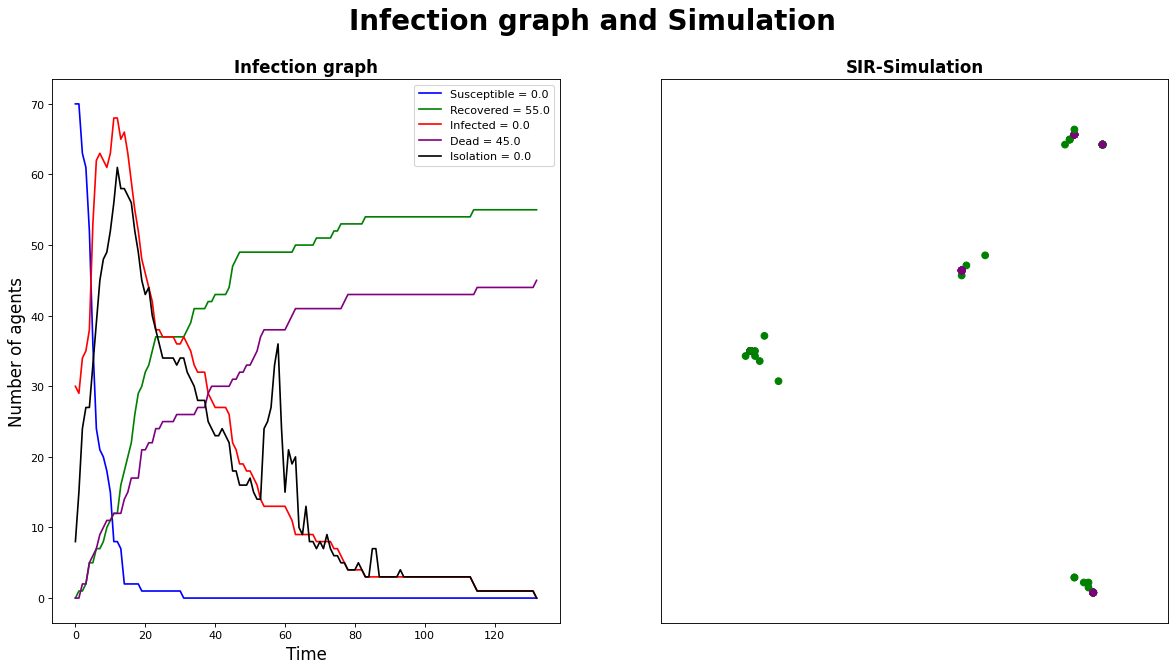

In [18]:
#@title # Körning av simuleringen{ form-width: "500px", display-mode: "form" }
#@markdown Kör först det ovanstående kodblocket för att initialisera alla funktioner.

# order of the parameters in the list sent to run_sir():
# [number_of_agents, initially_infected, test_capacity, false_tests_prob,
#  infection_rate, recovery_rate, death_rate, death_rate_old_people, loss_of_immunity_prob,
#  lockdown_start_time, lockdown_duration,proportion_of_old_people, mutation_start_time,
#  new_infection_rate, new_recovery_rate, new_death_rate, new_death_rate_old_people,
#  new_loss_of_immunity_prob, neural_network_activated, number_of_societies, travelrate, number_of_hotspot]
standard_values = [100,30,30,0,0.8,0.03,0.02,0.2,0,0,25,0,0,0,0,0,0,0,True,1,0,5]

#@markdown Standard simulering?
standard_simulation = True #@param {type:"boolean"}

#@markdown Samhällesinställningar
number_of_agents = 10000 #@param {type:"slider", min:100, max:10000, step:50}
initially_infected = 50 #@param {type:"slider", min:5, max:500, step:5}

#@markdown Testningsinställningar
test_capacity = 50 #@param {type:"slider", min:5, max:100, step:5}
false_tests_prob = 0 #@param {type:"slider", min:0, max:1, step:0.02}

#@markdown Sjukdomsinställningar
infection_rate = 0.9 #@param {type:"slider", min:0, max:1, step:0.02}
recovery_rate = 0.06 #@param {type:"slider", min:0, max:1, step:0.02}
death_rate = 0.02 #@param {type:"slider", min:0, max:1, step:0.02}

loss_of_immunity_prob = 0 #@param {type:"slider", min:0, max:1, step:0.02}

#@markdown Nedstängningsinställningar
lockdown_activated = False #@param {type:"boolean"}
lockdown_start_time = 150 #@param {type:"slider", min:0, max:250, step:25}
lockdown_duration = 50 #@param {type:"slider", min:25, max:200, step:25}
if not lockdown_activated:
    lockdown_start_time = 0

#@markdown Åldersinställningar
age_activated = False #@param {type:"boolean"}
proportion_of_old_people = 0.2 #@param {type:"slider", min:0, max:1, step:0.02}
death_rate_old_people = 0.04 #@param {type:"slider", min:0, max:1, step:0.02}
if not age_activated:
    proportion_of_old_people = 0
    death_rate_old_people = death_rate

#@markdown Mutationsinställningar
mutation_activated = False #@param {type:"boolean"}
mutation_start_time = 25 #@param {type:"slider", min:0, max:250, step:25}
new_infection_rate = 0.6 #@param {type:"slider", min:0, max:1, step:0.02}
new_recovery_rate = 0.01 #@param {type:"slider", min:0, max:1, step:0.02}
new_death_rate = 0.05 #@param {type:"slider", min:0, max:1, step:0.02}
new_death_rate_old_people = 0.1 #@param {type:"slider", min:0, max:1, step:0.02}
new_loss_of_immunity_prob = 0.2 #@param {type:"slider", min:0, max:1, step:0.02}
if not mutation_activated:
    mutation_start_time = 0 
    new_infection_rate = 0 
    new_recovery_rate = 0 
    new_death_rate = 0 
if (not age_activated) or (not mutation_activated):
    new_death_rate_old_people = 0 
    new_loss_of_immunity_prob = 0 

#@markdown Flera samhällen?
number_of_societies = 1 #@param ["1", "2", "4"] {type:"raw"}
number_of_societies = int(number_of_societies)
travelrate = 0.2 #@param {type:"slider", min:0, max:1, step:0.02}
travelrate = int(number_of_agents*travelrate)
#@markdown Neuralt nätverk aktiverat? 
neural_network_activated = True #@param {type:"boolean"}

#@markdown Number of hotspots
number_of_hostspots = 5 #@param {type:"slider", min:0, max:100, step:1}

if standard_simulation:
    running_values = standard_values
else:
    running_values = [number_of_agents, initially_infected, test_capacity, false_tests_prob,
    infection_rate, recovery_rate, death_rate, death_rate_old_people, loss_of_immunity_prob,
    lockdown_start_time, lockdown_duration,proportion_of_old_people, mutation_start_time,
    new_infection_rate, new_recovery_rate, new_death_rate, new_death_rate_old_people,
    new_loss_of_immunity_prob, neural_network_activated,number_of_societies, travelrate]

run_sir(running_values)